Импортируем библиотеки, которые понадобятся в текущем проекте

In [2]:
!pip install cmake
!pip install dlib


In [3]:
import cv2
import numpy as np
import dlib
import requests
from PIL import Image

скачиваем готовую модель для распознавания объекта на изображении

In [4]:
pip install wget


Note: you may need to restart the kernel to use updated packages.


In [5]:
import wget
url = 'https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat'

wget.download(url, 'C:/Users/user/Desktop/Face Swap/model.dat')



100% [........................................................................] 99693937 / 99693937

'C:/Users/user/Desktop/Face Swap/model (1).dat'

Создаём функцию, которая извлекает индексы из массива

In [6]:
def extract_index_nparray(array):
    index = None
    for num in array[0]:
        index = num
        break
    return index

Загрузим изображение первое изображение, с которого будем "вырезать" лицо

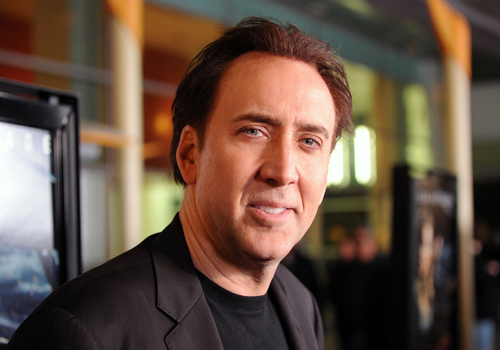

In [7]:
image1 = Image.open(requests.get('https://peopletalk.ru/wp-content/uploads/2016/09/GettyImages-109358284-1.jpg', stream=True).raw)
image1 = image1.resize((500,350))
image1

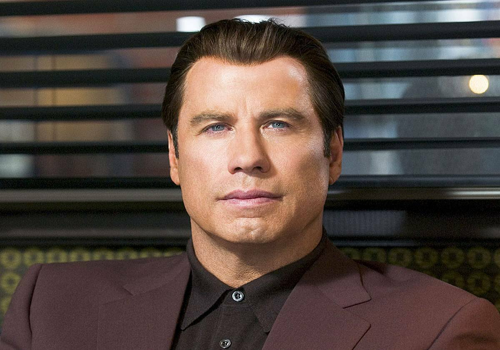

In [8]:
image2 = Image.open(requests.get('https://avatars.mds.yandex.net/get-zen_doc/1906877/pub_5e54e08fe977e25b8eec7a32_5e54e1a4b7ff5817661e7c22/scale_1200', stream=True).raw)
image2 = image2.resize((500,350))
image2

Переведём изображения в массив, предварительно сделав их черно-белыми

In [9]:
img = np.array(image1)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = np.array(image2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

Создаём детектор лица и пустой массив для хранения лица

In [10]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("C:/Users/user/Desktop/Face Swap/model.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

Сохраняем извлеченные точки ориентиров x и y в список. Производим триангуляцию изображения

In [11]:
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

повторим этот же пункт для целевого изображения

In [12]:
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)


создадим пустые массивы для помощи в дальнейших операциях

In [13]:
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

После того, как у нас есть триангуляция обоих изображений, мы берем треугольники исходного изображения и извлекаем их. Нам также нужно взять координаты треугольников целевого изображения , чтобы мы могли деформировать треугольники исходного, чтобы они имели одни и те же размеры.

In [14]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

Мы просто перестраиваем изображение, используя шаблон триангуляции, с той лишь разницей, что на этот раз мы помещаем новые треугольники.

In [15]:
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

Мы берем новое лицо и целевое изображение без лица и связываем их вместе.

In [17]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

Наконец, лица правильно поменялись местами, и надо настроить цвета так, чтобы исходное изображение соответствовало целевому изображению.

In [18]:
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

Переводиим массив в изображение

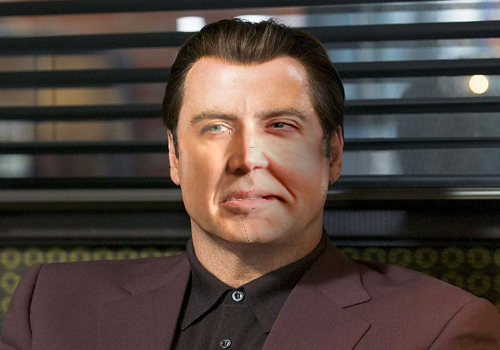

In [19]:
Image.fromarray(seamlessclone)

# :)